### Import necessary files

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, losses
import matplotlib.pyplot as plt

### Configure the file path, model and image configuration

In [2]:
LFW_DIR = r"E:\lfw_funneled"     # Path to LFW folder
PAIRS_FILE = r"E:\pairs.txt"     # Path to pairs.txt
IMG_SIZE = 96
EMBEDDING_DIM = 128
BATCH_SIZE = 32
EPOCHS = 10

### Function for image load, and normalization

In [3]:
def load_image(person, img_num):
    filename = f"{person}/{person}_{img_num:04d}.jpg"
    path = os.path.join(LFW_DIR, filename)
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return img.astype(np.float32)

### Create tuple of name and image. Each tuple contains two pairs. {(name1, image1), (name1, image2)}. If the pair are same level is become 1 otherwise 0.

In [4]:
def parse_pairs_file(pairs_file, max_pairs=1000):
    pairs, labels = [], []
    with open(pairs_file, "r") as f:
        lines = f.readlines()[1:]
        for line in lines:
            if len(pairs) >= max_pairs:
                break
            parts = line.strip().split()
            if len(parts) == 3:
                pairs.append(((parts[0], int(parts[1])), (parts[0], int(parts[2]))))
                labels.append(1)
            elif len(parts) == 4:
                pairs.append(((parts[0], int(parts[1])), (parts[2], int(parts[3]))))
                labels.append(0)
    return pairs, labels

### Generate pairs

In [5]:
def generate_batch_pairs(pairs, labels, batch_size):
    while True:
        idxs = np.random.choice(len(pairs), batch_size)
        batch_x1, batch_x2, batch_y = [], [], []
        for i in idxs:
            (p1, n1), (p2, n2) = pairs[i]
            batch_x1.append(load_image(p1, n1))
            batch_x2.append(load_image(p2, n2))
            batch_y.append(labels[i])
        yield [np.array(batch_x1), np.array(batch_x2)], np.array(batch_y).reshape(-1, 1)

def generate_batch_triplets(pairs, labels, batch_size):
    while True:
        anchors, positives, negatives = [], [], []
        for _ in range(batch_size):
            pos_idx = np.random.choice(np.where(np.array(labels)==1)[0])
            (p_a, n_a), (p_p, n_p) = pairs[pos_idx]
            anchor = load_image(p_a, n_a)
            positive = load_image(p_p, n_p)
            neg_idx = np.random.choice(np.where(np.array(labels)==0)[0])
            (p_n1, n_n1), (_, _) = pairs[neg_idx]
            negative = load_image(p_n1, n_n1)
            anchors.append(anchor)
            positives.append(positive)
            negatives.append(negative)
        yield [np.array(anchors), np.array(positives), np.array(negatives)], np.zeros((batch_size,))

### Create model

In [6]:
def create_embedding_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), embedding_dim=EMBEDDING_DIM):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)
    return models.Model(inputs, x)

### All loss implementation

In [7]:
bce_loss_fn = losses.BinaryCrossentropy(from_logits=False)

def contrastive_loss(margin=1.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        pos = y_true * tf.square(y_pred)
        neg = (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0))
        return tf.reduce_mean(pos + neg)
    return loss

def triplet_loss(margin=0.5):
    def loss(_, y_pred):
        d = tf.shape(y_pred)[1] // 3
        a, p, n = y_pred[:, :d], y_pred[:, d:2*d], y_pred[:, 2*d:]
        pos_dist = tf.reduce_sum(tf.square(a - p), axis=1)
        neg_dist = tf.reduce_sum(tf.square(a - n), axis=1)
        return tf.reduce_mean(tf.maximum(pos_dist - neg_dist + margin, 0.0))
    return loss

### Build models according to the loss

In [9]:
def build_bce_model():
    base = create_embedding_model()
    i1 = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    i2 = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    e1, e2 = base(i1), base(i2)
    diff = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([e1, e2])
    out = layers.Dense(1, activation='sigmoid')(diff)
    model = models.Model([i1, i2], out)
    model.compile(optimizer='adam', loss=bce_loss_fn, metrics=['accuracy'])
    return model

In [10]:
def build_contrastive_model():
    base = create_embedding_model()
    i1 = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    i2 = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    e1, e2 = base(i1), base(i2)
    dist = layers.Lambda(lambda x: tf.sqrt(tf.reduce_sum(tf.square(x[0] - x[1]), axis=1, keepdims=True)))([e1, e2])
    model = models.Model([i1, i2], dist)
    model.compile(optimizer='adam', loss=contrastive_loss(), metrics=['accuracy'])
    return model

In [11]:
def build_triplet_model():
    base = create_embedding_model()
    ia = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    ip = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    ineg = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    ea, ep, en = base(ia), base(ip), base(ineg)
    merged = layers.Concatenate()([ea, ep, en])
    model = models.Model([ia, ip, ineg], merged)
    model.compile(optimizer='adam', loss=triplet_loss())
    return model

### Vizalization of pairs or image show

In [12]:
def visualize_bce_pairs(pairs, labels, n=3):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        (p1, n1), (p2, n2) = pairs[i]
        img1 = load_image(p1, n1)
        img2 = load_image(p2, n2)
        plt.subplot(n, 2, i * 2 + 1)
        plt.imshow(img1)
        plt.title(f"Person: {p1}")
        plt.axis('off')
        plt.subplot(n, 2, i * 2 + 2)
        plt.imshow(img2)
        plt.title("Same" if labels[i] == 1 else "Diff")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_triplet(pairs, labels, n=3):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        pos_idx = np.where(np.array(labels) == 1)[0][i]
        (p_a, n_a), (p_p, n_p) = pairs[pos_idx]
        anchor = load_image(p_a, n_a)
        positive = load_image(p_p, n_p)

        neg_idx = np.where(np.array(labels) == 0)[0][i]
        (p_n1, n_n1), (_, _) = pairs[neg_idx]
        negative = load_image(p_n1, n_n1)

        plt.subplot(n, 3, i*3 + 1)
        plt.imshow(anchor); plt.title("Anchor"); plt.axis('off')
        plt.subplot(n, 3, i*3 + 2)
        plt.imshow(positive); plt.title("Positive"); plt.axis('off')
        plt.subplot(n, 3, i*3 + 3)
        plt.imshow(negative); plt.title("Negative"); plt.axis('off')
    plt.tight_layout()
    plt.show()

### Train the model

In [13]:
def train_model(model, generator, steps, epochs, name=""):
    print(f"\nTraining [{name}] model for {epochs} epochs:")
    history = model.fit(generator, steps_per_epoch=steps, epochs=epochs, verbose=1)
    losses = history.history['loss']
    print(f"\nFinal Loss [{name}]: {losses[-1]:.4f}")
    return losses

### Plot the losses

In [14]:
def plot_losses(bce_losses, contrastive_losses, triplet_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(bce_losses, marker='o', label='BCE Loss')
    plt.plot(contrastive_losses, marker='o', label='Contrastive Loss')
    plt.plot(triplet_losses, marker='o', label='Triplet Loss')
    plt.title("Training Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

### Main function

Loaded 1000 pairs.


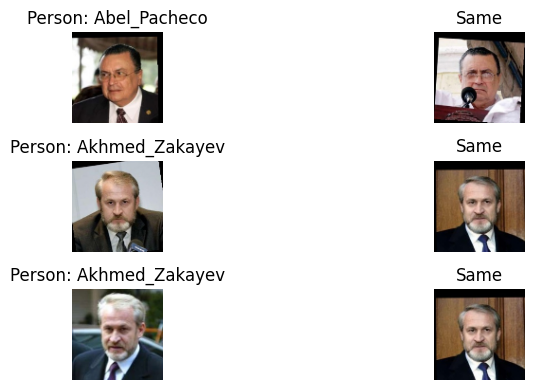

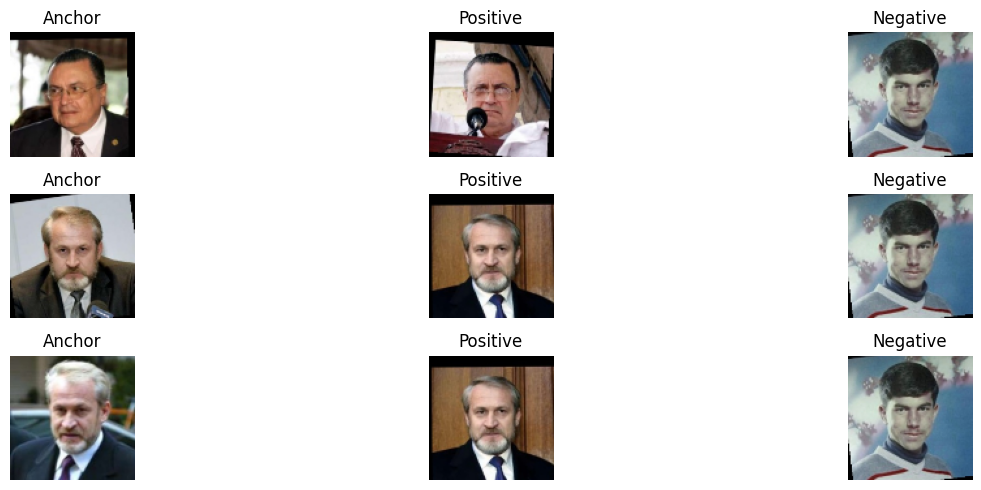


Training [BCE] model for 10 epochs:
Epoch 1/10
31/31 [==============================] - 9s 250ms/step - loss: 0.6533 - accuracy: 0.6462
Epoch 2/10
31/31 [==============================] - 8s 247ms/step - loss: 0.5469 - accuracy: 0.7893
Epoch 3/10
31/31 [==============================] - 7s 237ms/step - loss: 0.4130 - accuracy: 0.9194
Epoch 4/10
31/31 [==============================] - 7s 238ms/step - loss: 0.3089 - accuracy: 0.9446
Epoch 5/10
31/31 [==============================] - 7s 240ms/step - loss: 0.2363 - accuracy: 0.9758
Epoch 6/10
31/31 [==============================] - 7s 239ms/step - loss: 0.1596 - accuracy: 0.9929
Epoch 7/10
31/31 [==============================] - 8s 248ms/step - loss: 0.1170 - accuracy: 0.9960
Epoch 8/10
31/31 [==============================] - 8s 250ms/step - loss: 0.0860 - accuracy: 0.9990
Epoch 9/10
31/31 [==============================] - 8s 243ms/step - loss: 0.0631 - accuracy: 1.0000
Epoch 10/10
31/31 [==============================] - 8s 244ms/s

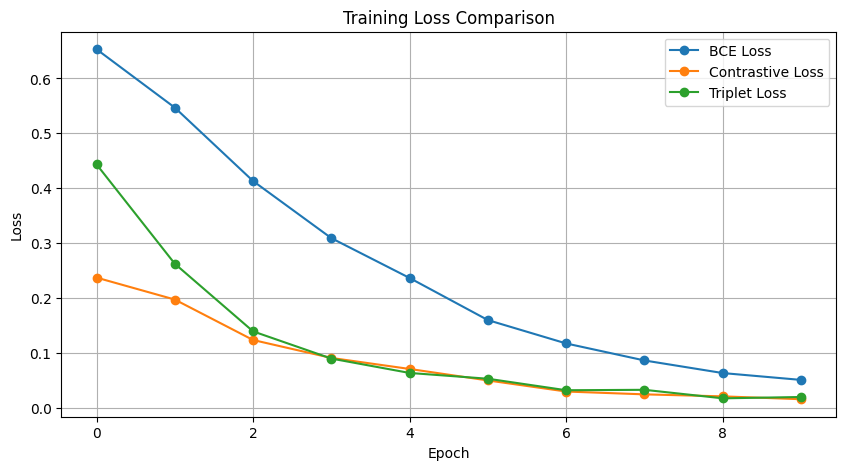

In [15]:
def main():
    pairs, labels = parse_pairs_file(PAIRS_FILE, max_pairs=1000)
    print(f"Loaded {len(pairs)} pairs.")

    visualize_bce_pairs(pairs, labels)
    visualize_triplet(pairs, labels)

    bce_model = build_bce_model()
    contrastive_model = build_contrastive_model()
    triplet_model = build_triplet_model()

    steps = len(pairs) // BATCH_SIZE

    bce_losses = train_model(bce_model, generate_batch_pairs(pairs, labels, BATCH_SIZE), steps, EPOCHS, name="BCE")
    contrastive_losses = train_model(contrastive_model, generate_batch_pairs(pairs, labels, BATCH_SIZE), steps, EPOCHS, name="Contrastive")
    triplet_losses = train_model(triplet_model, generate_batch_triplets(pairs, labels, BATCH_SIZE), steps, EPOCHS, name="Triplet")

    print("\n===== Final Losses =====")
    print(f"BCE Final Loss:         {bce_losses[-1]:.4f}")
    print(f"Contrastive Final Loss: {contrastive_losses[-1]:.4f}")
    print(f"Triplet Final Loss:     {triplet_losses[-1]:.4f}")

    plot_losses(bce_losses, contrastive_losses, triplet_losses)

if __name__ == "__main__":
    main()